# CAD-DR: CAD Dimensionality Reduction

A deep convolutional autoencoder for dimensionality reduction of 3D CAD models

### Information
1. Ten-layer architecture (5 in encoder + 5 in decoder)
2. Dataset - 1000 STL files
3. Train - 800 models
4. Test - 200 models
5. Epochs - 50
6. Point cloud density - 20k points

### Metrics
1. loss: 0.0180
2. accuracy: 0.9920 (99.20%)
3. val_loss: 0.0120
4. val_accuracy: 0.9948 (99.48%)

### Encoder architecture
- Conv3D(32, (3, 3, 3), activation='selu', padding='same')
- AveragePooling3D((2, 2, 2), padding='same')
- Conv3D(16, (3, 3, 3), activation='selu', padding='same')
- AveragePooling3D((2, 2, 2), padding='same')

#### Run this cell in case you haven't installed the required libraries

In [ ]:
!pip install numpy pandas pyntcloud open3d tqdm
!pip install tensorflow[and-cuda]

### Importing all necessary libraries

In [30]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, UpSampling3D, AveragePooling3D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

Download a chunk of the ABC dataset. Extract and move 1000 STL files to the abc-dataset-stl directory which will be automatically created by running the cell below. The STL to point-cloud conversion will store the generated point-clouds in abc-dataset-ply directory, and checkpoints will be stored in the checkpoints directory. Additionally, trained models will be saved to the saved-models directory. All these directories will be created by running the cell below. The user will only have the run the cell below, download and extract the STL files to abc-dataset-stl directory.

In [ ]:
os.mkdir("abc-dataset-stl")
os.mkdir("abc-dataset-ply")
os.mkdir("checkpoints")
os.mkdir("saved-models")

### Converting STL to point cloud

**Execute the following cell if you wish to delete all existing point cloud files in abc-dataset-ply/ directory**

In [2]:
folder_path = "abc-dataset-ply\\"
files = os.listdir(folder_path)

for file in files:
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file}: {str(e)}")

**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [4]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl\\"))

for i in tqdm(files, desc="Converting STL to Point-Cloud", unit="file"):
    path = "abc-dataset-stl\\" + i
    ConversionUtils.stl_to_ply(path, 20000)

Converting STL to Point-Cloud: 100%|██████████| 1000/1000 [18:17<00:00,  1.10s/file]  


### Converting point cloud to binary voxel arrays

In [5]:
directory = "abc-dataset-ply\\"

files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in tqdm(files, desc="Processing files", unit="file"):
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path, 64)
    dataset.append(binvox)

Processing files: 100%|██████████| 1000/1000 [00:43<00:00, 22.86file/s]


In [6]:
print(len(dataset))

1000


### Splitting dataset for training and testing

In [7]:
dataset = np.array(dataset)

train_dataset_length = int(0.8 * len(dataset))
test_set_length = int(0.2 * len(dataset))

train_dataset = dataset[:train_dataset_length]  
test_dataset = dataset[train_dataset_length:]   
print("Length of training dataset:", len(train_dataset))
print("Length of test dataset:", len(test_dataset))

input_shape = (64, 64, 64, 1)

Length of training dataset: 800
Length of test dataset: 200


### Encoder

In [8]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(input_data)
x = AveragePooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(x)
encoded = AveragePooling3D((2, 2, 2), padding='same')(x)

### Decoder

In [9]:
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Callbacks

#### Early Stopping

In [10]:
early_stopping = EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
)

#### Checkpoint

In [11]:
checkpoint_filepath = 'checkpoints\\checkpoint.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

### Training autoencoder, prediction done on test dataset

In [12]:
BATCH_SIZE = 10
EPOCHS = 50

In [13]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder.fit(train_dataset, train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_dataset, test_dataset), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/50
80/80 [==============================] - 68s 296ms/step - loss: 0.1053 - accuracy: 0.9731 - val_loss: 0.0587 - val_accuracy: 0.9730
Epoch 2/50
80/80 [==============================] - 23s 289ms/step - loss: 0.0485 - accuracy: 0.9771 - val_loss: 0.0497 - val_accuracy: 0.9754
Epoch 3/50
80/80 [==============================] - 23s 293ms/step - loss: 0.0440 - accuracy: 0.9784 - val_loss: 0.0462 - val_accuracy: 0.9767
Epoch 4/50
80/80 [==============================] - 23s 293ms/step - loss: 0.0403 - accuracy: 0.9800 - val_loss: 0.0433 - val_accuracy: 0.9783
Epoch 5/50
80/80 [==============================] - 24s 296ms/step - loss: 0.0380 - accuracy: 0.9813 - val_loss: 0.0402 - val_accuracy: 0.9796
Epoch 6/50
80/80 [==============================] - 24s 296ms/step - loss: 0.0349 - accuracy: 0.9832 - val_loss: 0.0363 - val_accuracy: 0.9823
Epoch 7/50
80/80 [==============================] - 24s 297ms/step - loss: 0.0319 - accuracy: 0.9849 - val_loss: 0.0341 - val_accuracy: 0.9836

In [14]:
reconstructed_data = autoencoder.predict(test_dataset, batch_size=BATCH_SIZE)

20/20 [==============================] - 2s 87ms/step


In [15]:
encoder = Model(autoencoder.input, autoencoder.layers[5].output)
encoded_data = encoder.predict(test_dataset, batch_size=BATCH_SIZE)

20/20 [==============================] - 1s 41ms/step


### Saving autoencoder and encoder

In [16]:
autoencoder.save("saved-models\\autoencoder.keras")
encoder.save("saved-models\\encoder.keras")

### Dimensions

In [17]:
print("Shape of input data: ", test_dataset[0].shape)
print("Shape of encoded data: ", encoded_data[0].shape)
print("Shape of reconstructed data: ", reconstructed_data[0].shape)

original_points = 64**3
reduced_points = 16**4
print("\nOriginal data points: " + str(original_points))
print("Data points in encoded data: " + str(reduced_points))
print("Reduction: " + str((original_points - reduced_points) * 100 / original_points) + "%")

Shape of input data:  (64, 64, 64)
Shape of encoded data:  (16, 16, 16, 16)
Shape of reconstructed data:  (64, 64, 64, 1)

Original data points: 262144
Data points in encoded data: 65536
Reduction: 75.0%


### Sample reconstruction from test dataset

In [20]:
import matplotlib.pyplot as plt

index = 90 # change this value to visualize different models and their reconstructions

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

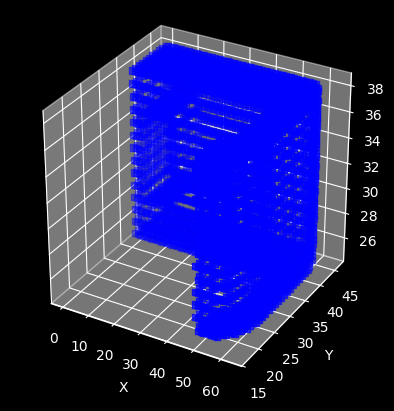

In [21]:
Visualization.matplotlib_visualize_original(original_sample)

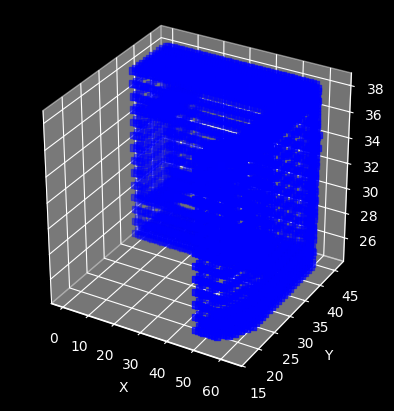

In [22]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [23]:
Visualization.open3d_visualize_original(original_sample)

In [24]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)

### Visualizing encoded data

In [25]:
sample_encoded_data = encoded_data[index]
print(sample_encoded_data.shape)

(16, 16, 16, 16)


In [26]:
print(sample_encoded_data)

[[[[-2.45791733e-01 -3.38745922e-01 -1.20358698e-01 ... -1.88363269e-01
    -7.67062083e-02 -2.83235550e-01]
   [-2.78169185e-01 -3.63431990e-01 -8.59093294e-02 ... -2.53390163e-01
    -1.36013702e-01 -3.10710281e-01]
   [-2.96904355e-01 -3.78768474e-01 -8.16886574e-02 ... -2.57109106e-01
    -1.56697437e-01 -3.05765331e-01]
   ...
   [-2.96904355e-01 -3.78768474e-01 -8.16886574e-02 ... -2.57109106e-01
    -1.56697437e-01 -3.05765331e-01]
   [-2.95404315e-01 -3.67842942e-01 -1.14652820e-01 ... -2.60224313e-01
    -1.75880834e-01 -2.97019094e-01]
   [-3.03192616e-01 -2.03350887e-01 -1.82605818e-01 ... -2.58114338e-01
    -1.37333676e-01 -1.98026448e-01]]

  [[-2.34742478e-01 -3.84926796e-01 -2.53579885e-01 ... -1.77106991e-01
    -8.88012648e-02 -2.05162942e-01]
   [-2.17337668e-01 -4.14815873e-01 -1.88659474e-01 ... -2.74480760e-01
    -1.88332140e-01 -2.82508671e-01]
   [-2.33254135e-01 -4.36989933e-01 -1.83264256e-01 ... -2.87729889e-01
    -2.06526741e-01 -2.82109529e-01]
   ...
   

In [27]:
threshold = 0.35
binary_arrays = (sample_encoded_data >= threshold).astype(int)
print(binary_arrays)

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [

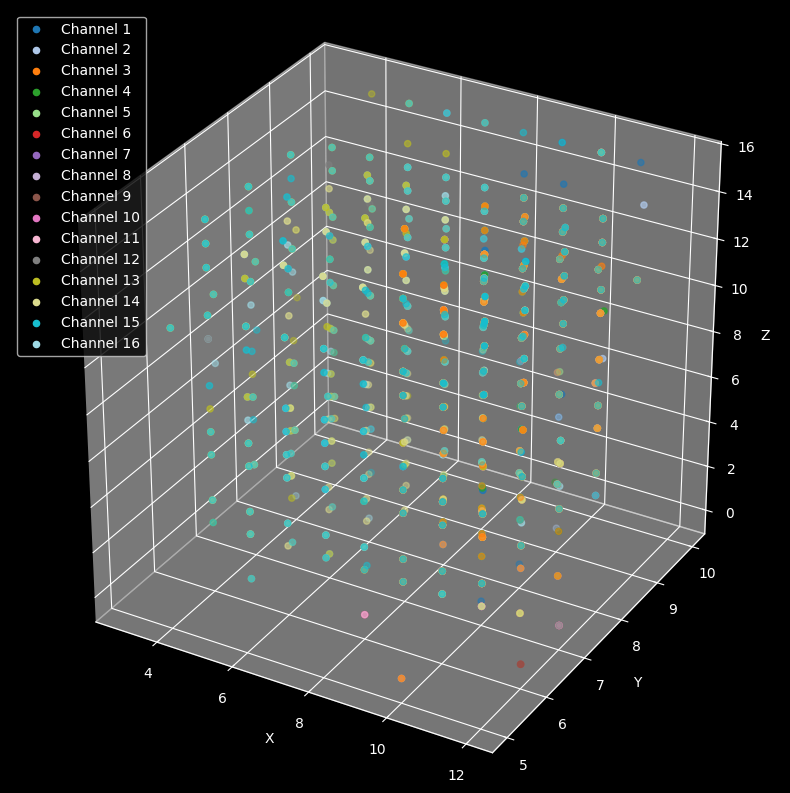

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap('tab20', len(binary_arrays))

for i, binary_array in enumerate(binary_arrays):
    x, y, z = np.where(binary_array == 1)
    ax.scatter(x, y, z, c=colors(i), marker='o', s=20, label=f'Channel {i + 1}')

ax.set_box_aspect([1, 1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

plt.show()